In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
from pandas.core.common import SettingWithCopyWarning

import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

import random
import datetime
import time
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset
import torch.optim as optim


In [2]:
# Initialise the random state
num = random.randint(1, 500)

torch.manual_seed(num)
print(f"The generated random seed is {num}") #347

The generated random seed is 76


In [3]:
# Load the processed emg data
emg_path = "/Users/niharawarawita/Desktop/MSc Project/Data/EMG_data_collection/emg_combined_stats.csv"
emg_df = pd.read_csv(emg_path)
emg_df.head()

,new_id,id,p_id,itr_id,prj_id,ppt_id,rating,hand,clt_id,ch_01,ch_02,ch_03,ch_04,ch_05,ch_06,ch_07,ch_08,timestamp
0,1,132383,19,119,622,16,6,0,27,0.001062,0.003030,0.002932,0.006998,0.010902,0.016429,0.024816,0.034724,2022-02-13 11:24:11.302
1,2,132383,19,119,622,16,6,0,27,0.001062,0.011202,0.002932,0.001948,0.002860,0.000817,0.015065,0.004675,2022-02-13 11:24:11.302
2,3,132383,19,119,622,16,6,0,27,0.001062,0.003030,0.002932,0.001948,0.002860,0.014796,0.004439,0.024374,2022-02-13 11:24:11.302
3,4,132383,19,119,622,16,6,0,27,0.001062,0.003030,0.006901,0.001948,0.002860,0.014796,0.005313,0.044074,2022-02-13 11:24:11.302
4,5,132383,19,119,622,16,6,0,27,0.001062,0.003030,0.002932,0.001948,0.002860,0.014796,0.005313,0.004675,2022-02-13 11:24:11.302


### Preprocess the emg data

In [4]:
emg_df.rename(columns={'p_id': 'participant_id', 'itr_id': 'interaction_id',  'prj_id': 'project_id',  'ppt_id': 'property_id', 'clt_id': 'clothes_id'}, inplace=True)
emg_df.head()

,new_id,id,participant_id,interaction_id,project_id,property_id,rating,hand,clothes_id,ch_01,ch_02,ch_03,ch_04,ch_05,ch_06,ch_07,ch_08,timestamp
0,1,132383,19,119,622,16,6,0,27,0.001062,0.003030,0.002932,0.006998,0.010902,0.016429,0.024816,0.034724,2022-02-13 11:24:11.302
1,2,132383,19,119,622,16,6,0,27,0.001062,0.011202,0.002932,0.001948,0.002860,0.000817,0.015065,0.004675,2022-02-13 11:24:11.302
2,3,132383,19,119,622,16,6,0,27,0.001062,0.003030,0.002932,0.001948,0.002860,0.014796,0.004439,0.024374,2022-02-13 11:24:11.302
3,4,132383,19,119,622,16,6,0,27,0.001062,0.003030,0.006901,0.001948,0.002860,0.014796,0.005313,0.044074,2022-02-13 11:24:11.302
4,5,132383,19,119,622,16,6,0,27,0.001062,0.003030,0.002932,0.001948,0.002860,0.014796,0.005313,0.004675,2022-02-13 11:24:11.302


In [5]:
emg_df.drop(['new_id', 'id', 'project_id'], axis=1, inplace=True)
emg_df.head()

,participant_id,interaction_id,property_id,rating,hand,clothes_id,ch_01,ch_02,ch_03,ch_04,ch_05,ch_06,ch_07,ch_08,timestamp
0,19,119,16,6,0,27,0.001062,0.003030,0.002932,0.006998,0.010902,0.016429,0.024816,0.034724,2022-02-13 11:24:11.302
1,19,119,16,6,0,27,0.001062,0.011202,0.002932,0.001948,0.002860,0.000817,0.015065,0.004675,2022-02-13 11:24:11.302
2,19,119,16,6,0,27,0.001062,0.003030,0.002932,0.001948,0.002860,0.014796,0.004439,0.024374,2022-02-13 11:24:11.302
3,19,119,16,6,0,27,0.001062,0.003030,0.006901,0.001948,0.002860,0.014796,0.005313,0.044074,2022-02-13 11:24:11.302
4,19,119,16,6,0,27,0.001062,0.003030,0.002932,0.001948,0.002860,0.014796,0.005313,0.004675,2022-02-13 11:24:11.302


In [6]:
# Convert the timestamp to the datetime format
emg_df['timestamp']= pd.to_datetime(emg_df['timestamp'])

In [7]:
# Sort the values in each df by ascending value of the timestamp
emg_df.sort_values(by=['timestamp'], inplace=True)

In [8]:
# Split the data into hands 0 (left) and 1 (right)
emg_0 = emg_df[emg_df.hand == 0]
emg_1 = emg_df[emg_df.hand == 1]

# Reset indexes
emg_0.reset_index(inplace=True, drop = True)
emg_1.reset_index(inplace=True, drop = True)


In [9]:
def interaction_time(df):
    # Create a column for the starting time of each interaction 
    df['interaction_start_time'] = df['timestamp'].groupby(df['interaction_id']).transform('min')
    # Create a column for the ending time of each interaction 
    df['interaction_end_time'] = df['timestamp'].groupby(df['interaction_id']).transform('max')
    
    df['interaction_duration'] = df['interaction_end_time'] - df['interaction_start_time']#.datetime.total_seconds()
    df['interaction_duration'] = df['interaction_duration'].dt.total_seconds()
    return df

emg_0 = interaction_time(emg_0)
emg_1 = interaction_time(emg_1)


In [10]:
def emg_get_15_seconds(interaction_id, emg_interaction_df, emg_df):
    interaction_end_time = emg_interaction_df.iloc[0,16]
    threshold = interaction_end_time - datetime.timedelta(0,16)

    # Remove rows with interaction_id with a timestamp less than the threshold from the dfs
    emg_df.drop(emg_df[(emg_df.interaction_id==interaction_id) & (emg_df.timestamp<=threshold)].index, inplace=True)
    
    # Drop the interaction_start_time and interaction_end_time for the dfs
    emg_df.drop(['interaction_start_time', 'interaction_end_time', 'interaction_duration'], axis=1, inplace=True)

    # Recalculate the columns
    emg_df = interaction_time(emg_df)
     
    return emg_df

emg_191_0 = emg_0[emg_0.interaction_id==191]
emg_0 = emg_get_15_seconds(191, emg_191_0, emg_0) 
emg_196_0 = emg_0[emg_0.interaction_id==196]
emg_0 = emg_get_15_seconds(196, emg_196_0, emg_0) 

emg_191_1 = emg_1[emg_1.interaction_id==191]
emg_1 = emg_get_15_seconds(191, emg_191_1, emg_1)  
emg_196_1 = emg_1[emg_1.interaction_id==196]
emg_1 = emg_get_15_seconds(196, emg_196_1, emg_1)  
emg_296_1 = emg_1[emg_1.interaction_id==296]
emg_1 = emg_get_15_seconds(296, emg_296_1, emg_1) 



In [11]:
def add_property_names_column(df):
    df.insert(3, 'property_name', 'smoothness')
    df.property_name[df['property_id'] == 13] = 'thickness'
    df.property_name[df['property_id'] == 14] = 'warmth'
    df.property_name[df['property_id'] == 15] = 'flexibility'
    df.property_name[df['property_id'] == 16] = 'softness'
    df.property_name[df['property_id'] == 17] = 'enjoyment'
    return df

emg_0 = add_property_names_column(emg_0)
emg_1 = add_property_names_column(emg_1)


In [12]:
emg_0 = emg_0[emg_0.property_name != 'enjoyment']
emg_1 = emg_1[emg_1.property_name != 'enjoyment']


In [13]:
def renumber_socks(df):
    df.clothes_id[(df['clothes_id'] == 25) | (df['clothes_id'] == 31) | (df['clothes_id'] == 38) | (df['clothes_id'] == 44) | (df['clothes_id'] == 50) | (df['clothes_id'] == 56)] = 1
    df.clothes_id[(df['clothes_id'] == 26) | (df['clothes_id'] == 32) | (df['clothes_id'] == 39) | (df['clothes_id'] == 45) | (df['clothes_id'] == 51) | (df['clothes_id'] == 57)] = 2
    df.clothes_id[(df['clothes_id'] == 27) | (df['clothes_id'] == 33) | (df['clothes_id'] == 40) | (df['clothes_id'] == 46) | (df['clothes_id'] == 52) | (df['clothes_id'] == 58)] = 3
    df.clothes_id[(df['clothes_id'] == 28) | (df['clothes_id'] == 34) | (df['clothes_id'] == 41) | (df['clothes_id'] == 47) | (df['clothes_id'] == 53) | (df['clothes_id'] == 59)] = 4
    df.clothes_id[(df['clothes_id'] == 29) | (df['clothes_id'] == 35) | (df['clothes_id'] == 42) | (df['clothes_id'] == 48) | (df['clothes_id'] == 54) | (df['clothes_id'] == 60)] = 5
    df.clothes_id[(df['clothes_id'] == 30) | (df['clothes_id'] == 36) | (df['clothes_id'] == 43) | (df['clothes_id'] == 49) | (df['clothes_id'] == 55) | (df['clothes_id'] == 61)] = 6
    return df

emg_0 = renumber_socks(emg_0)
emg_1 = renumber_socks(emg_1)


In [14]:
def combine_classes_rating(df):
    df.insert(5, 'rating_level', 'medium')
    df.loc[df['rating'] > 5,'rating_level'] = 'high'
    df.loc[df['rating'] < 3,'rating_level'] = 'low'
    return df
    
emg_0 = combine_classes_rating(emg_0)
emg_1 = combine_classes_rating(emg_1)


In [15]:
def represent_rating_level_numerically(df):
    df.insert(6, 'rating_level_num', 1)
    df.loc[df['rating_level'] == 'medium','rating_level_num'] = 2
    df.loc[df['rating_level'] == 'high','rating_level_num'] = 3
    return df

emg_0 = represent_rating_level_numerically(emg_0)
emg_1 = represent_rating_level_numerically(emg_1)


In [16]:
def create_subwindows(df, num_subwindows=15):
    
    # Create a column with the subwindow numbers
    df.insert(9, 'sub_window_num', num_subwindows)
    for num in range(num_subwindows-1,0,-1):
        df.sub_window_num[pd.to_datetime(df['timestamp']) <= pd.to_datetime(df['interaction_start_time']) + datetime.timedelta(0,num)] = num
        
    return df

emg_0 = create_subwindows(emg_0, num_subwindows=15)
emg_1 = create_subwindows(emg_1, num_subwindows=15)



In [17]:
def downsample_emg(df):
    column_names = ['ch_01','ch_02','ch_03','ch_04','ch_05','ch_06','ch_07','ch_08']
    for col in column_names:
        new_col_name = 'mean_'+col           
        df[new_col_name] = df[col].groupby([df['interaction_id'], df['sub_window_num']]).transform('mean')
    return df


emg_0 = downsample_emg(emg_0)
emg_1 = downsample_emg(emg_1)



In [18]:
emg_0_new = emg_0[['participant_id','clothes_id', 'property_id','property_name','interaction_id','hand','rating','rating_level','rating_level_num', 'sub_window_num', 'mean_ch_01','mean_ch_02','mean_ch_03','mean_ch_04','mean_ch_05','mean_ch_06','mean_ch_07','mean_ch_08']]
emg_1_new = emg_1[['participant_id','clothes_id', 'property_id','property_name','interaction_id','hand','rating','rating_level','rating_level_num', 'sub_window_num', 'mean_ch_01','mean_ch_02','mean_ch_03','mean_ch_04','mean_ch_05','mean_ch_06','mean_ch_07','mean_ch_08']]


In [19]:
print(emg_0_new.shape)
print(emg_0_new.shape)

(1307504, 18)
(1307504, 18)


In [20]:
# Remove duplicates
emg_0_new.drop_duplicates(keep='first', inplace=True)
emg_1_new.drop_duplicates(keep='first', inplace=True)

# Reset the indexes
emg_0_new.reset_index(drop=True, inplace=True) 
emg_1_new.reset_index(drop=True, inplace=True) 


In [21]:
print(emg_0_new.shape)
print(emg_0_new.shape)

(2694, 18)
(2694, 18)


max: 15
min: 9
mean: 15.0
std: 0.4


<AxesSubplot:xlabel='interaction_id'>

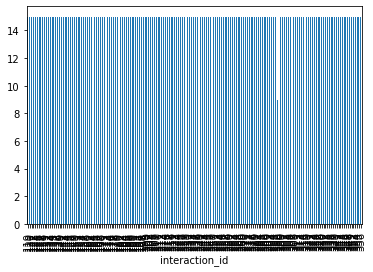

In [22]:
df0 = emg_0_new.groupby('interaction_id')['sub_window_num'].nunique()
print(f'max: {df0.max()}')
print(f'min: {df0.min()}')
print(f'mean: {round(df0.mean(),1)}')
print(f'std: {round(df0.std(),1)}')
df0.plot.bar()

max: 15
min: 9
mean: 15.0
std: 0.5


<AxesSubplot:xlabel='interaction_id'>

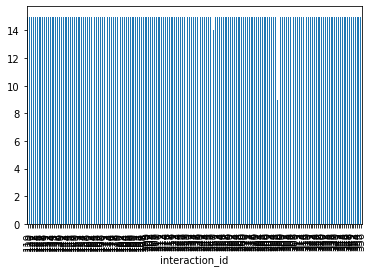

In [23]:
df1 = emg_1_new.groupby('interaction_id')['sub_window_num'].nunique()
print(f'max: {df1.max()}')
print(f'min: {df1.min()}')
print(f'mean: {round(df1.mean(),1)}')
print(f'std: {round(df1.std(),1)}')
df1.plot.bar()

### Create X and y data

In [24]:
def create_X(df):
    dim1 = df.interaction_id.nunique()
    #num_timestamps_per_interaction = df.groupby('interaction_id')['sub_window_num'].nunique()
    dim2 = df.sub_window_num.nunique()
        
    X = np.zeros((dim1, dim2, 8)) 

    itr_id_lst = df.interaction_id.unique().tolist()

    for i in range(len(itr_id_lst)):
        itr_id = itr_id_lst[i]
        itr_id_df = df[df.interaction_id==itr_id]       
        
        for j in range(itr_id_df.shape[0]):
            starting_index = 10
            vals_arr = itr_id_df.iloc[j,starting_index:].values
            X[i,j] = vals_arr
    
    X_tensor = torch.Tensor(X)    
    return X_tensor


In [25]:
def create_y_train(df, predicting_feature = 'property_id'):
    # Create a dataset with only the required columns
    df2 = df[['participant_id', 'clothes_id', 'property_id', 'rating_level_num']]

    # Remove duplicates
    df2.drop_duplicates(keep='first', inplace=True)

    # Reset the indexes
    df2.reset_index(drop=True, inplace=True) 
    
    ## Create y train
    # CreatE an instance of a one-hot-encoder
    encoder = OneHotEncoder(handle_unknown='ignore')

    # Perform one-hot encoding on the specified column 
    encoder_df = pd.DataFrame(encoder.fit_transform(df2[[predicting_feature]]).toarray())
    
    # Convert to a numpy array
    y_train = encoder_df.to_numpy()
    
    # Convert to a tensor
    y_train = torch.Tensor(y_train)
  
    return y_train


In [35]:
def create_y_test(df, predicting_feature = 'property_id'):
    # Create a dataset with only the required columns
    df2 = df[['participant_id', 'clothes_id', 'property_id', 'rating_level_num']]

    # Remove duplicates
    df2.drop_duplicates(keep='first', inplace=True)

    # Reset the indexes
    df2.reset_index(drop=True, inplace=True) 
    
    y_test = df2[predicting_feature].values
    y_test = y_test - 12
    y_test = torch.Tensor(y_test)
    
    #y_test = y_test.type(torch.LongTensor)
    
    return y_test


### Create the model

input1 = torch.rand(180,15,8)
input2 = torch.rand(180,15,5*2)
conv1 = nn.Conv1d(in_channels=15, out_channels=15, kernel_size=1, stride=1, padding=0, groups=15) # Change kernel size to 3
pool = nn.MaxPool1d(1, 1) # Change kernel size to 1 and stride to 1
rnn = nn.LSTM(8, 5, 1)
h0 = torch.randn(1, 10, 5)
c0 = torch.randn(1, 10, 5)
fc1 = nn.Linear(15 * 5 * 2, 50)
fc2 = nn.Linear(50, 5)

print(input1.shape)
x=conv1(input1)
print(x.shape)
x=pool(x)
print(x.shape)
x, (hn,cn) = rnn(x)
print(x.shape)
print('=================')
y = torch.flatten(input2, 1)
print(y.shape)
y = fc1(y)
print(y.shape)
y = fc2(y)
print(y.shape)





In [45]:
class CNN_LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv1d(in_channels=15, out_channels=15, kernel_size=1, stride=1, padding=0, groups=15) # Change kernel size to 3
        self.pool = nn.MaxPool1d(1, 1) # Change kernel size to 1 and stride to 1
        self.rnn = nn.LSTM(8, 8, 1)
        self.h0 = torch.randn(1, 15, 8)
        self.c0 = torch.randn(1, 15, 8)
        self.fc1 = nn.Linear(15 * 8 * 2, 70)
        self.fc2 = nn.Linear(70, 5)
        
           
    def forward(self, x1, x2):
        x1 = self.pool(F.relu(self.conv1(x1))) # Use tanh instead?
        x2 = self.pool(F.relu(self.conv1(x2))) # Use tanh instead?
        
        #x = self.pool(F.relu(self.conv2(x)))
        x1, (hn, cn) = self.rnn(x1, (self.h0, self.c0))
        x2, (hm, cm) = self.rnn(x2, (self.h0, self.c0))
        
        x = torch.cat((x1, x2), 2)
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x))
        return x
        

In [46]:
m = CNN_LSTM()
print(m)

CNN_LSTM(
  (conv1): Conv1d(15, 15, kernel_size=(1,), stride=(1,), groups=15)
  (pool): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (rnn): LSTM(8, 8)
  (fc1): Linear(in_features=240, out_features=70, bias=True)
  (fc2): Linear(in_features=70, out_features=5, bias=True)
)


In [51]:
def plot_loss(num_epochs, loss_vals):
    plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), loss_vals)
    plt.show

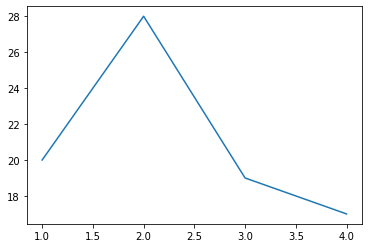

In [52]:
plot_loss(4, [20,28,19,17])

In [58]:
def NN_LOSO(data_0, data_1, predicting_feature='property_id', batch_size=50, learning_rate=0.01, num_epochs=100, random_state=num): #, num_inner_folds=5

    # Set fixed random number seed
    torch.manual_seed(num)
    
    for cloth_id in range(1,7): 
        # Split the data into training and testing
        training_data_0 = data_0[data_0.clothes_id != cloth_id] 
        training_data_1 = data_1[data_1.clothes_id != cloth_id] 
        testing_data_0 = data_0[data_0.clothes_id == cloth_id] 
        testing_data_1 = data_1[data_1.clothes_id == cloth_id] 

        # Data preparation
        X_train_0 = create_X(training_data_0)
        X_train_1 = create_X(training_data_1)        
        y_train = create_y_train(training_data_0, predicting_feature = 'property_id')
        X_test_0 = create_X(testing_data_0) 
        X_test_1 = create_X(testing_data_1)
        y_test = create_y_test(testing_data_0, predicting_feature = 'property_id')
        
 
        # Create the datasets and dataloaders
        train_dataset = TensorDataset(X_train_0, X_train_1, y_train) 
        train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
        
        test_dataset = TensorDataset(X_test_0, X_test_1, y_test) 
        test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=30, shuffle=True, num_workers=2)
        
        # Model
        model = CNN_LSTM()

        # Loss and Optimiser
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
        
        print('Starting training.')
        training_loss = []
        
        for epoch in range(num_epochs):  # loop over the dataset multiple times

            running_loss = 0.0
            for i, data in enumerate(train_dataloader, 0):
                # get the inputs; data is a list of [input1, input2, label]
                input1, input2, labels = data

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = model(input1, input2)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # Update statistics
                running_loss += loss.item()
                
            training_loss.append(running_loss)
            
       # print(num_epochs, training_loss)
        plot_loss(num_epochs, training_loss)
        
        print('Training done.')

        # save trained model - this is the last model saved 
        torch.save(model.state_dict(), 'saved_model.pt')
        print('Model saved.')
        
        print('Starting testing')
        
        dataiter = iter(test_dataloader)
 
        # load the trained model
        class_model = CNN_LSTM()
        class_model.load_state_dict(torch.load('saved_model.pt'))

        # inference
        test_input1, test_input2, test_labels = dataiter.next()
        test_labels = test_labels.type(torch.LongTensor)

        test_outputs = class_model(test_input1, test_input2)
        _, predicted = torch.max(test_outputs, 1) # Does the same thing as argmax
        
        predicted_np = predicted.numpy()
        labels_np = test_labels.numpy()        

        conf_mat = confusion_matrix(labels_np, predicted_np, labels=[0, 1, 2, 3, 4])
        macro_f1_score = f1_score(labels_np, predicted_np, average='macro') 
        micro_f1_score = f1_score(labels_np, predicted_np, average='micro')  
        acc = accuracy_score(labels_np, predicted_np)

        print(f'Leaving sock {cloth_id} out:') 
        print("(1) Confusion matrix:\n", conf_mat)
        print(f"(2) micro F1 score = {round(micro_f1_score,2)}")
        print(f"(3) macro F1 score = {round(macro_f1_score,2)}")    
        print(f"(4) Percentage Classification accuracy = {round(acc*100,2)}%")


        print('--------------------------------------------------')
        
        
        
        
   
        
        
    
  

In [ ]:
NN_LOSO(emg_0_new, emg_1_new, predicting_feature='property_id', batch_size=50, learning_rate=0.01, num_epochs=10, random_state=num)



Starting training.
Training done.
Model saved.
Starting testing
Leaving sock 1 out:
(1) Confusion matrix:
 [[0 0 6 0 0]
 [0 0 6 0 0]
 [0 0 6 0 0]
 [0 0 6 0 0]
 [0 0 6 0 0]]
(2) micro F1 score = 0.2
(3) macro F1 score = 0.07
(4) Percentage Classification accuracy = 20.0%
--------------------------------------------------
Starting training.
Training done.
Model saved.
Starting testing
Leaving sock 2 out:
(1) Confusion matrix:
 [[0 0 0 6 0]
 [0 0 0 6 0]
 [0 0 1 5 0]
 [0 0 0 6 0]
 [0 0 0 6 0]]
(2) micro F1 score = 0.23
(3) macro F1 score = 0.13
(4) Percentage Classification accuracy = 23.33%
--------------------------------------------------
Starting training.


In [32]:
dxtfcygvuhbijnokp

NameError: name 'dxtfcygvuhbijnokp' is not defined

In [ ]:
  
#def CV(data, num_inner_folds=5, learning_rate, num_epochs=1, random_state=num)
num_inner_folds=2
# Set fixed random number seed
torch.manual_seed(num)
#for cloth_id in range(1,7): 
    ## For fold results
   # results = {}

data = emg_0_new.copy()
# Split the data into training and testing
training_data = data[data.clothes_id != 1] #cloth_id
testing_data = data[data.clothes_id == 1] #cloth_id

# Data preparation
X_train_0 = create_X(emg_0_new)  
X_test_0 = create_X(emg_0_new) 
y_train = create_y(emg_0_new, predicting_feature = 'property_id')

X_train_1 = create_X(emg_1_new) 
X_test_1 = create_X(emg_1_new)
y_test = create_y(emg_0_new, predicting_feature = 'property_id')

# Create the datasets and dataloaders
train_dataset = TensorDataset(X_train_0, X_train_1, y_train) 
test_dataset = TensorDataset(X_test_0, X_test_1, y_test) 
test_dataloader = torch.utils.data.DataLoader(test_dataset) #, batch_size=batch_size, shuffle=True, num_workers=2)


# Configure the cross-validation procedure
cv_inner = KFold(n_splits=num_inner_folds, shuffle=True, random_state=num)

for fold, (train_ids, val_ids) in enumerate(cv_inner.split(train_dataset)):
    print(f'FOLD {fold+1}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids) # The ids are the same for both
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

    # Define data loaders for training and testing data in this fold
    train_dataloader = torch.utils.data.DataLoader(train_dataset, sampler=train_subsampler)
    val_dataloader = torch.utils.data.DataLoader(train_dataset, sampler=val_subsampler)
    
    # Model
    model = CNN_LSTM()

    # Loss and Optimiser
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(train_dataloader, 0):
            # get the inputs; data is a list of [input1, input2, label]
            input1, input2, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(input1, input2)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Update statistics
            running_loss += loss.item()
            
    # Process is complete.
    print('Training process has finished. Saving trained model.')

        training_loss.append(running_loss)
        if training_loss < lowest_loss:
            lowest_loss = training_loss
            
                
    plot_loss(np.linspace(1, num_epochs, num_epochs).astype(int), training_loss)
        
        
    print('Training done.')

    # save trained model    
    torch.save(model.state_dict(), 'saved_model.pt')
    print('Model saved.')
 
    # Print statistics
    current_loss += loss.item()
    if i % 500 == 499:
        print('Loss after mini-batch %5d: %.3f' %
              (i + 1, current_loss / 500))
        current_loss = 0.0

# Process is complete.
print('Training process has finished. Saving trained model.')

# Print about testing
print('Starting testing')

# Saving the model
save_path = f'./model-fold-{fold}.pth'
torch.save(network.state_dict(), save_path)

# Evaluationfor this fold
correct, total = 0, 0
with torch.no_grad():

  # Iterate over the test data and generate predictions
  for i, data in enumerate(testloader, 0):

    # Get inputs
    inputs, targets = data

    # Generate outputs
    outputs = network(inputs)

    # Set total and correct
    _, predicted = torch.max(outputs.data, 1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

  # Print accuracy
  print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
  print('--------------------------------')
  results[fold] = 100.0 * (correct / total)

# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
sum = 0.0
for key, value in results.items():
print(f'Fold {key}: {value} %')
sum += value
print(f'Average: {sum/len(results.items())} %')








# Prepare MNIST dataset by concatenating Train/Test part; we split later.
#dataset_train_part = MNIST(os.getcwd(), download=True, transform=transforms.ToTensor(), train=True)
#dataset_test_part = MNIST(os.getcwd(), download=True, transform=transforms.ToTensor(), train=False)
#dataset = ConcatDataset([dataset_train_part, dataset_test_part])





# Define the K-fold Cross Validator
#kfold = KFold(n_splits=k_folds, shuffle=True)

# Start print
#print('--------------------------------')

# K-fold Cross Validation model evaluation
'''

In [ ]:
def plot_loss(epochs, loss_vals):
    plt.plot(epochs, loss)
    
def train(df, config):#, y_train, lr=0.001, num_epochs=1000):
    
    
    train_dataset = TensorDataset(X_train, y_train) 
    train_dataloader = torch.utils.data.DataLoader(train_dataset) #, batch_size=batch_size, shuffle=True, num_workers=2)

    ## Model
    model = CNN_LSTM()

    ## Loss and Optimiser
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=config["lr"])

    
    ## Train
    print('Starting training.')
    training_loss = []
    lowest_loss = np.inf
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(train_dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Update statistics
            running_loss += loss.item()
            
        training_loss.append(running_loss)
        if training_loss < lowest_loss:
            lowest_loss = training_loss
            
                
    plot_loss(np.linspace(1, num_epochs, num_epochs).astype(int), training_loss)
        
        
    print('Training done.')

    # save trained model    
    torch.save(model.state_dict(), 'saved_model.pt')
    print('Model saved.')

In [ ]:
#if __name__ == '__main__':
def testing(X_test, y_test, predicting_feature='new_property_id'):

    #batch_size = 18
    test_dataset = TensorDataset(X_test, y_test) 
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    dataiter = iter(test_dataloader)
    #if predicting_feature=='new_property_id':
       # classes = ('smoothness', 'thickness', 'warmth', 'flexibility', 'softness')
    #elif predicting_feature == 'new_rating_level_num':
        #classes = (1,2,3,4,5,6,7)


    ## load the trained model
    class_model = CNN_LSTM()
    class_model.load_state_dict(torch.load('saved_model.pt'))


    ## inference
    images, labels = dataiter.next()
    labels = labels.reshape([batch_size])
    labels = labels.type(torch.LongTensor)
    #print('Ground-truth: ', ' '.join('%5s' % classes[labels_3[j]] for j in range(batch_size)))

    outputs = class_model(images)
    _, predicted = torch.max(outputs, 1)
    #print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(batch_size)))
    
    labels_np = labels.numpy()
    predicted_np = predicted.numpy()
    
    if predicting_feature=='new_property_id':
        conf_mat = confusion_matrix(labels_np, predicted_np, labels=[0, 1, 2, 3, 4])
        macro_f1_score = f1_score(labels_np, predicted_np, average='macro') 
    elif predicting_feature=='new_rating_level_num':
        conf_mat = confusion_matrix(labels_np, predicted_np, labels=[0, 1, 2]) 
        weighted_f1_score = f1_score(labels_np, predicted_np, average='weighted') 
    micro_f1_score = f1_score(labels_np, predicted_np, average='micro')  
    acc = accuracy_score(labels_np, predicted_np)
     
    if predicting_feature == 'new_property_id':
        print(f'Using a CNN+LSTM for automatic property recognition:') 
    elif predicting_feature == 'new_rating_level_num':
        print(f'Using a CNN+LSTM for automatic rating prediction:')    
    print("(1) Confusion matrix:\n", conf_mat)
    print(f"(2) micro F1 score = {round(micro_f1_score,2)}")
    if predicting_feature == 'new_property_id':
        print(f"(3) macro F1 score = {round(macro_f1_score,2)}")
    elif predicting_feature == 'new_rating_level_num':
        print(f"(3) weighted F1 score = {round(weighted_f1_score,2)}")      
    print(f"(4) Percentage Classification accuracy = {round(acc*100,2)}%")



    





In [ ]:
def NN_LOCOCV_properties(data, num_inner_folds=5, predicting_feature = 'property_id', random_state=num):
    #if predicting_feature == 'property_id':
    #    print(f'Classification accuracy when predicting properties at random : {round(1/len(data.property_id.unique())*100,2)}% ')
    #else:
    #    print(f'Classification accuracy when predicting ratings at random : {round(1/len(data.rating_level_num.unique())*100,2)}% ')
    #print('__________________________________________')
        
    if predicting_feature == 'property_id':
        macro_f1_lst = []
    elif predicting_feature == 'rating_level_num':
        weighted_f1_lst = []    
    micro_f1_lst = []
    acc_lst = []
    for cloth_id in range(1,7):      
        # Split the data into training and testing
        training_data = data[data.clothes_id != cloth_id]
        testing_data = data[data.clothes_id == cloth_id]
        
        # Data preparation
        X_train = create_X(training_data)     
        y_train = create_y(training_data, predicting_feature = 'property_id')
        X_test = create_X(testing_data)         
        y_test = create_y(testing_data, predicting_feature = 'property_id')
        
        # Configure the cross-validation procedure
        cv_inner = KFold(n_splits=num_inner_folds, shuffle=True, random_state=num)
        
        # Define the model
        NN_model = CNN_LSTM()
        
        # Create a dictionary with the hyperparameters to tune
        features_dict = dict()
        features_dict['n_estimators'] = [100, 500, 1000, 1500]
        
        # Define the Grid Search
        if predicting_feature == 'property_id':
            search = GridSearchCV(rf_model, features_dict, scoring='f1_macro', cv=cv_inner, refit=True) #accuracy
        elif predicting_feature == 'rating_level_num':
            search = GridSearchCV(rf_model, features_dict, scoring='f1_weighted', cv=cv_inner, refit=True) #accuracy
        
        # Execute the search
        result = search.fit(X_train, y_train)    
        
        # Obtain the best performing model fit on the whole training set
        best_rf_model = result.best_estimator_
        
        # Using the model, obtain predictions for the test data
        predictions = best_rf_model.predict(X_test)
        
        # Evaluate the model
        if predicting_feature == 'property_id':
            conf_mat = confusion_matrix(y_test, predictions, labels=[12, 13, 14, 15, 16])
            macro_f1_score = f1_score(y_test, predictions, average='macro') 
            macro_f1_lst.append(macro_f1_score) 
        elif predicting_feature == 'rating_level_num':
            conf_mat = confusion_matrix(y_test, predictions, labels=[1,2,3])
            weighted_f1_score = f1_score(y_test, predictions, average='weighted') 
            weighted_f1_lst.append(weighted_f1_score) 
            
        micro_f1_score = f1_score(y_test, predictions, average='micro')  
        micro_f1_lst.append(micro_f1_score)
        acc = accuracy_score(y_test, predictions)
        acc_lst.append(acc)
        
        print(f'Leaving sock {cloth_id} out {result.best_params_}:') 
        print("(1) Confusion matrix:\n", conf_mat)
        print(f"(2) Micro F1 score = {round(micro_f1_score,2)}")
        if predicting_feature == 'property_id':
            print(f"(3) Macro F1 score = {round(macro_f1_score,2)}")
        elif predicting_feature == 'rating_level_num':
            print(f"(3) Weighted F1 score = {round(weighted_f1_score,2)}")            
        print(f"(4) Percentage Classification accuracy = {round(acc*100,2)}%")

        print('__________________________________________')    

    avg_micro_f1_score = sum(micro_f1_lst) / len(micro_f1_lst)
    if predicting_feature == 'property_id':
        avg_macro_f1_score = sum(macro_f1_lst) / len(macro_f1_lst)
    elif predicting_feature == 'rating_level_num':
        avg_weighted_f1_score = sum(weighted_f1_lst) / len(weighted_f1_lst)               
    avg_acc = sum(acc_lst) / len(acc_lst)   
    
    print(f'Using Leave One Cloth Out CV (LOCOCV):') 
    print(f"(1) Average micro F1 score = {round(avg_micro_f1_score,2)}")
    if predicting_feature == 'property_id':
        print(f"(2) Average macro F1 score = {round(avg_macro_f1_score,2)}")
    elif predicting_feature == 'rating_level_num':
        print(f"(2) Average weighted F1 score = {round(avg_weighted_f1_score,2)}")      
    print(f"(3) Average Percentage Classification accuracy = {round(avg_acc*100,2)}%")




In [ ]:
print(X_train.shape)
print(y_train.shape)

In [ ]:
    
batch_size = X_train.shape[0]
train_dataset = TensorDataset(X_train, y_train) 
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

## Model
model = CNN_LSTM()


## Loss and Optimiser
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


## Train
print('Starting training.')
#for epoch in range(10):  # loop over the dataset multiple times

running_loss = 0.0
for i, data in enumerate(train_dataloader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    #labels = labels.reshape([batch_size])
    #labels = labels.type(torch.LongTensor)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(inputs)
    #print(outputs)
    #print(labels)
    loss = criterion(outputs, labels)
    #print(loss)
    #print('--------------')
    #loss.backward()
    #optimizer.step()

    # Update statistics
    #running_loss += loss.item()



In [ ]:
np.linspace(1, 10, 10).astype(int)

In [ ]:
X = 
training(X_train, y_train)

In [ ]:
#if __name__ == '__main__':
def testing(X_test, y_test, predicting_feature='new_property_id'):

    batch_size = 18
    test_dataset = TensorDataset(X_test, y_test) 
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    dataiter = iter(test_dataloader)
    #if predicting_feature=='new_property_id':
       # classes = ('smoothness', 'thickness', 'warmth', 'flexibility', 'softness')
    #elif predicting_feature == 'new_rating_level_num':
        #classes = (1,2,3,4,5,6,7)


    ## load the trained model
    class_model = CNN_LSTM()
    class_model.load_state_dict(torch.load('saved_model.pt'))


    ## inference
    images, labels = dataiter.next()
    labels = labels.reshape([batch_size])
    labels = labels.type(torch.LongTensor)
    #print('Ground-truth: ', ' '.join('%5s' % classes[labels_3[j]] for j in range(batch_size)))

    outputs = class_model(images)
    _, predicted = torch.max(outputs, 1)
    #print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(batch_size)))
    
    labels_np = labels.numpy()
    predicted_np = predicted.numpy()
    
    if predicting_feature=='new_property_id':
        conf_mat = confusion_matrix(labels_np, predicted_np, labels=[0, 1, 2, 3, 4])
        macro_f1_score = f1_score(labels_np, predicted_np, average='macro') 
    elif predicting_feature=='new_rating_level_num':
        conf_mat = confusion_matrix(labels_np, predicted_np, labels=[0, 1, 2]) 
        weighted_f1_score = f1_score(labels_np, predicted_np, average='weighted') 
    micro_f1_score = f1_score(labels_np, predicted_np, average='micro')  
    acc = accuracy_score(labels_np, predicted_np)
     
    if predicting_feature == 'new_property_id':
        print(f'Using a CNN+LSTM for automatic property recognition:') 
    elif predicting_feature == 'new_rating_level_num':
        print(f'Using a CNN+LSTM for automatic rating prediction:')    
    print("(1) Confusion matrix:\n", conf_mat)
    print(f"(2) micro F1 score = {round(micro_f1_score,2)}")
    if predicting_feature == 'new_property_id':
        print(f"(3) macro F1 score = {round(macro_f1_score,2)}")
    elif predicting_feature == 'new_rating_level_num':
        print(f"(3) weighted F1 score = {round(weighted_f1_score,2)}")      
    print(f"(4) Percentage Classification accuracy = {round(acc*100,2)}%")



    




In [ ]:
# Predicting properties

# Create the training and testing data
X_train, X_test, y_train, y_test = data_preparation(emg_data, starting_index = 13, predicting_feature='new_property_id', random_state=num)
print('----------------------------')
# Train the model
training(X_train, y_train)
print('----------------------------')
# Test the model
testing(X_test, y_test, predicting_feature='new_property_id')


In [ ]:
print(x.shape)
x = fc1(x)
print(x.shape)
x = fc2(x)
print(x.shape)
x = fc3(x)
print(x.shape)

In [ ]:
arr1 = np.random.rand(180, 8, 15)
inp1 = torch.Tensor(arr) 
arr2 = np.random.rand(180, 8, 15)
inp2 = torch.Tensor(arr) 

conv1 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=2, stride=1, padding=0) # Change kernel size to 3
pool = nn.MaxPool1d(2, 2) # Change kernel size to 1
rnn = nn.LSTM(7, 5, 1)
h0 = torch.randn(1, 8, 5)
c0 = torch.randn(1, 8, 5)
fc1 = nn.Linear(8 * 10, 50)
fc2 = nn.Linear(50, 5)
#fc3 = nn.Linear(220, 5)

#print(inp.shape)
x = (F.relu(conv1(inp1))) # Try tanh instead
#print(x.shape)
x = (pool(x))
#print(x.shape)
x, (hn, cn) = rnn(x, (h0, c0))
#print(x.shape)


y = (F.relu(conv1(inp2))) # Try tanh instead
#print(y.shape)
y = (pool(y))
#print(y.shape)
y, (hm, cm) = rnn(y, (h0, c0))
#print(y.shape)

z = torch.cat((x, y), 2)
print(z.shape)
z = torch.flatten(z, 1) # flatten all dimensions except batch
print(z.shape)
z = fc1(z)
print(z.shape)
z = fc2(z)
print(z.shape)






In [ ]:
def data_preparation(emg_data, starting_index = 13, predicting_feature='new_property_id', random_state=num):
    
    X_arr = emg_data.iloc[:,starting_index:].values
    print(f'X_arr before reshaping {X_arr.shape}')
    X_arr = X_arr.reshape((int(X_arr.shape[0]/3), 3, int(X_arr.shape[1])),order='F')
    print(f'X_arr after reshaping {X_arr.shape}')
    
    #y_arr = emg_data.new_property_id.values
    y_arr = emg_data[predicting_feature].values
    y_arr = y_arr[0::3]
    print(f'y_arr before reshaping {y_arr.shape}')
    y_arr = np.reshape(y_arr, (y_arr.shape[0],1))
    print(f'y_arr after reshaping {y_arr.shape}')
    
    # Create training and testing datasets
    X_train, X_test, y_train, y_test = train_test_split(X_arr, y_arr, test_size = 0.1, shuffle=True, random_state = num) 

    # transform arrays to torch tensors
    tensor_X_train = torch.Tensor(X_train) 
    tensor_X_test = torch.Tensor(X_test) 
    tensor_y_train = torch.Tensor(y_train)
    tensor_y_test = torch.Tensor(y_test)
    
    return tensor_X_train, tensor_X_test, tensor_y_train, tensor_y_test





In [ ]:
emg_data

In [ ]:
# Predicting rating
# Create the training and testing data
#property_id_lst = [12,13,14,15,16]
property_lst = ['smoothness', 'thickness', 'warmth', 'flexibility', 'softness']#, 'enjoyment']
#print(f'Classification accuracy when predicting properties at random: {round((1/7)*100,2)}% ')
for prop in property_lst:
    # Create dataset
    property_data = emg_data[emg_data.property_name == prop]
    print(prop)
    X_train, X_test, y_train, y_test = data_preparation(property_data, starting_index = 13, predicting_feature='new_rating_level_num', random_state=num)
    print('----------------------------')
    # Train the model
    training(X_train, y_train)
    print('----------------------------')
    # Test the model
    testing(X_test, y_test, predicting_feature='new_rating_level_num')



In [ ]:
fchgvjhbkjnl

In [ ]:
xtdrycfguvhibjonl

In [ ]:
def rf_LOCOCV_properties(data, num_inner_folds=5, predicting_feature = 'property_id', random_state=num):
    if predicting_feature == 'property_id':
        print(f'Classification accuracy when predicting properties at random : {round(1/len(data.property_id.unique())*100,2)}% ')
    else:
        print(f'Classification accuracy when predicting ratings at random : {round(1/len(data.rating_level_num.unique())*100,2)}% ')
    print('__________________________________________')
        
    if predicting_feature == 'property_id':
        macro_f1_lst = []
    elif predicting_feature == 'rating_level_num':
        weighted_f1_lst = []    
    micro_f1_lst = []
    acc_lst = []
    for cloth_id in range(1,7):      
        # Split the data into training and testing
        training_data = data[data.clothes_id != cloth_id]
        testing_data = data[data.clothes_id == cloth_id]
        
        # Data preparation
        starting_index = 11
        X_train = training_data.iloc[:,starting_index:].values        
        y_train = training_data[predicting_feature].values
        X_test = testing_data.iloc[:,starting_index:].values        
        y_test = testing_data[predicting_feature].values
        
        # Configure the cross-validation procedure
        cv_inner = KFold(n_splits=num_inner_folds, shuffle=True, random_state=num)
        
        # Define the model
        rf_model = RandomForestClassifier(random_state=num)
        
        # Create a dictionary with the hyperparameters to tune
        features_dict = dict()
        features_dict['n_estimators'] = [100, 500, 1000, 1500]
        
        # Define the Grid Search
        if predicting_feature == 'property_id':
            search = GridSearchCV(rf_model, features_dict, scoring='f1_macro', cv=cv_inner, refit=True) #accuracy
        elif predicting_feature == 'rating_level_num':
            search = GridSearchCV(rf_model, features_dict, scoring='f1_weighted', cv=cv_inner, refit=True) #accuracy
        
        # Execute the search
        result = search.fit(X_train, y_train)    
        
        # Obtain the best performing model fit on the whole training set
        best_rf_model = result.best_estimator_
        
        # Using the model, obtain predictions for the test data
        predictions = best_rf_model.predict(X_test)
        
        # Evaluate the model
        if predicting_feature == 'property_id':
            conf_mat = confusion_matrix(y_test, predictions, labels=[12, 13, 14, 15, 16])
            macro_f1_score = f1_score(y_test, predictions, average='macro') 
            macro_f1_lst.append(macro_f1_score) 
        elif predicting_feature == 'rating_level_num':
            conf_mat = confusion_matrix(y_test, predictions, labels=[1,2,3])
            weighted_f1_score = f1_score(y_test, predictions, average='weighted') 
            weighted_f1_lst.append(weighted_f1_score) 
            
        micro_f1_score = f1_score(y_test, predictions, average='micro')  
        micro_f1_lst.append(micro_f1_score)
        acc = accuracy_score(y_test, predictions)
        acc_lst.append(acc)
        
        print(f'Leaving sock {cloth_id} out {result.best_params_}:') 
        print("(1) Confusion matrix:\n", conf_mat)
        print(f"(2) Micro F1 score = {round(micro_f1_score,2)}")
        if predicting_feature == 'property_id':
            print(f"(3) Macro F1 score = {round(macro_f1_score,2)}")
        elif predicting_feature == 'rating_level_num':
            print(f"(3) Weighted F1 score = {round(weighted_f1_score,2)}")            
        print(f"(4) Percentage Classification accuracy = {round(acc*100,2)}%")

        print('__________________________________________')    

    avg_micro_f1_score = sum(micro_f1_lst) / len(micro_f1_lst)
    if predicting_feature == 'property_id':
        avg_macro_f1_score = sum(macro_f1_lst) / len(macro_f1_lst)
    elif predicting_feature == 'rating_level_num':
        avg_weighted_f1_score = sum(weighted_f1_lst) / len(weighted_f1_lst)               
    avg_acc = sum(acc_lst) / len(acc_lst)   
    
    print(f'Using Leave One Cloth Out CV (LOCOCV):') 
    print(f"(1) Average micro F1 score = {round(avg_micro_f1_score,2)}")
    if predicting_feature == 'property_id':
        print(f"(2) Average macro F1 score = {round(avg_macro_f1_score,2)}")
    elif predicting_feature == 'rating_level_num':
        print(f"(2) Average weighted F1 score = {round(avg_weighted_f1_score,2)}")      
    print(f"(3) Average Percentage Classification accuracy = {round(avg_acc*100,2)}%")



In [ ]:
X_arr = create_X(emg_0_new)
y_arr = create_y(emg_0_new, predicting_feature = 'property_id')

In [ ]:
X_arr.shape

In [ ]:
X_arr.shape

In [ ]:
path = "/Users/niharawarawita/Desktop/MSc Project/Data/EMG_data_collection/combined_stats_nihara.csv"
data = pd.read_csv(path)
data.head()

In [ ]:
# Obtain only the physical properties
physical_data = data[data.property_name != 'enjoyment']
physical_data.reset_index(inplace=True, drop = True)
physical_data.head()

In [ ]:
physical_data.property_id.unique()

In [ ]:
physical_data.insert(3, 'new_property_id', 20)
physical_data['new_property_id'] = physical_data['property_id'] - 12

physical_data.insert(9, 'new_rating_level_num', 10)
physical_data['new_rating_level_num'] = physical_data['rating_level_num'] - 1
physical_data.head()

In [ ]:
# Obtain only the EMG data
ending_index = 61
emg_data = physical_data.iloc[:, :ending_index]
emg_data

In [ ]:
print(emg_data.property_name.unique())
print(emg_data.new_property_id.unique())

In [ ]:
arr = np.random.rand(180, 8, 469)
inp = torch.Tensor(arr) 

conv1 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=2, stride=1, padding=0) # Change kernel size to 3
pool = nn.MaxPool1d(2, 2) # Change kernel size to 1
rnn = nn.LSTM(234, 150, 1)
h0 = torch.randn(1, 8, 150)
c0 = torch.randn(1, 8, 150)
fc1 = nn.Linear(8 * 150, 500)
fc2 = nn.Linear(500, 220)
fc3 = nn.Linear(220, 5)

print(inp.shape)
x = (F.relu(conv1(inp))) # Try tanh instead
print(x.shape)
x = (pool(inp))
print(x.shape)
x, (hn, cn) = rnn(x, (h0, c0))
print(x.shape)
x = torch.flatten(x, 1) # flatten all dimensions except batch
print(x.shape)
x = fc1(x)
print(x.shape)
x = fc2(x)
print(x.shape)
x = fc3(x)
print(x.shape)

In [ ]:
# Summarise and print the network architechture
m = CNN_LSTM()
print(f"Summary of the network architechture: {m}")

In [ ]:
drytfuygiuhi

In [ ]:
train_dataset = TensorDataset(tensor_X_train, tensor_y_train) 
train_dataloader = DataLoader(train_dataset) 

def foo():
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
            # get the inputs; data is a list of [inputs, labels]
        if i in range(2):
            b = labels




            print(inputs.shape,labels.shape, labels)
            print('-----------------------------------------------------------------------------------------------------------')
            return b

c= foo()
c.val

In [ ]:
type(c.item())

In [ ]:
     self.conv1 = nn.Conv1d(in_channels=3, out_channels=24, kernel_size=3, stride=1, padding=1) #3, 6, 5
        self.pool = nn.MaxPool2d(2, 2) # Kernel size of 2 and a stride of 2
        self.conv2 = nn.Conv1d(in_channels=12, out_channels=48, kernel_size=3, stride=1, padding=1) #3, 6, 5
        self.rnn = nn.LSTM(12, 18, 1)
        self.h0 = torch.randn(1, 24, 18)
        self.c0 = torch.randn(1, 24, 18)
        self.fc1 = nn.Linear(12 * 18, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 5)


In [ ]:




inpt = np.random.rand(1,3,48)
input_tensor = torch.Tensor(inpt)

conv1 = nn.Conv1d(in_channels=3, out_channels=24, kernel_size=3, stride=1, padding=1) #3, 6, 5
pool = nn.MaxPool2d(2, 2) # Kernel size of 2 and a stride of 2
conv2 = nn.Conv1d(in_channels=12, out_channels=48, kernel_size=3, stride=1, padding=1) #3, 6, 5
rnn = nn.LSTM(12, 18, 1)
h0 = torch.randn(1, 24, 18)
c0 = torch.randn(1, 24, 18)
fc1 = nn.Linear(24 * 18, 120)
fc2 = nn.Linear(120, 84)
fc3 = nn.Linear(84, 5)


  


x = pool(F.relu(conv1(input_tensor)))
print(x.shape)
x = pool(F.relu(conv2(x)))
print(x.shape)

x, (hn, cn) = rnn(x, (h0, c0))
print(x.shape)
x = torch.flatten(x, 1) # flatten all dimensions except batch
print(x.shape)
x = F.relu(fc1(x))
print(x.shape)
x = F.relu(fc2(x))
print(x.shape)
x = fc3(x)
print(x.shape)








      #  x = self.pool(F.relu(self.conv1(x)))

In [ ]:
cghvjbknl

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        print(x.shape)
        print(x)
        return x


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from PIL import Image    


if __name__ == '__main__':
    ## cifar-10 dataset
    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    batch_size = 20
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    # example images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    im = Image.fromarray((torch.cat(images.split(1,0),3).squeeze()/2*255+.5*255).permute(1,2,0).numpy().astype('uint8'))
    im.save("train_pt_images.jpg")
    print('train_pt_images.jpg saved.')
    print('Ground truth labels:' + ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


    ## cnn
    net = Net()


    ## loss and optimiser
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


    ## train
    for epoch in range(2):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            if i in range(2):
                print(labels)
                print(labels.shape)
                
    

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from PIL import Image   
if __name__ == '__main__':
    ## cifar-10 dataset
    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    batch_size = 4

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
    dataiter = iter(testloader)
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


    ## load the trained model
    #model = Net()
    #model.load_state_dict(torch.load('saved_model.pt'))


    ## inference
    images, labels = dataiter.next()
    print(labels)
    print(labels.shape)
    print('Ground-truth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

    #outputs = model(images)
    #_, predicted = torch.max(outputs, 1)
    #print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

    # save to images
    #im = Image.fromarray((torch.cat(images.split(1,0),3).squeeze()/2*255+.5*255).permute(1,2,0).numpy().astype('uint8'))
    #im.save("test_pt_images.jpg")
    #print('test_pt_images.jpg saved.')

In [ ]:
batch_size = 54
train_dataset = TensorDataset(tensor_X_train, tensor_y_train) 
#train_dataloader = DataLoader(train_dataset) 
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
classes = (12.0,13.0,14.0,15.0,16.0)
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        print(labels.shape)
        labels_2 = labels.reshape([batch_size])
        #if i in range(2):
           # print(labels_2)
           # print(labels_2.shape)

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from PIL import Image

#from network_pt import Net

if __name__ == '__main__':
    ## cifar-10 dataset
    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    batch_size = 20
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    # example images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    im = Image.fromarray((torch.cat(images.split(1,0),3).squeeze()/2*255+.5*255).permute(1,2,0).numpy().astype('uint8'))
    im.save("train_pt_images.jpg")
    print('train_pt_images.jpg saved.')
    print('Ground truth labels:' + ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


    ## cnn
    net = Net()


    ## loss and optimiser
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


    ## train
    for epoch in range(2):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Training done.')

    # save trained model
    torch.save(net.state_dict(), 'saved_model.pt')
    print('Model saved.')

In [ ]:
cgfhgvjhbkjnl

In [ ]:
inpt = np.random.rand(4, 3, 32, 32)
input_tensor = torch.Tensor(inpt)

conv1 = nn.Conv2d(3, 6, 5)
pool = nn.MaxPool2d(2, 2)
conv2 = nn.Conv2d(6, 16, 5)
fc1 = nn.Linear(16 * 5 * 5, 120)
fc2 = nn.Linear(120, 84)
fc3 = nn.Linear(84, 10)

print(input_tensor.shape)
x = pool(F.relu(conv1(input_tensor)))
print(x.shape)
x = pool(F.relu(conv2(x)))
print(x.shape)
print('drfytguhjn')
x = torch.flatten(x, 1) # flatten all dimensions except batch
print(x.shape)
x = F.relu(fc1(x))
print(x.shape)
x = F.relu(fc2(x))
print(x.shape)
x = fc3(x)
print(x.shape)

In [ ]:
===========
rnn = nn.LSTM(features_in=10, features_out=20, num_layers=1)
is similar to lstm = tf.keras.layers.LSTM(features_out=20)
h0 = torch.randn(2, 3, 20)
>>> c0 = torch.randn(2, 3, 20)
>>> output, (hn, cn) = rnn(input, (h0, c0))

===========

rnn = nn.LSTM(10, 20, 1, batch_first=True)

#  [batch, sequence length, features]
input = torch.randn(5, 3, 10)

h0 = torch.randn(1, 5, 20)
c0 = torch.randn(1, 5, 20)
output, (hn, cn) = rnn(input, (h0, c0))

# output shape: [batch, sequence length, out features]
output.shape
===============



In [ ]:
conv1 = nn.Conv2d(3, 6, 5) # Input channel size is 3 as the images have 3 colour channels, output channel size is 6 and the kernel size is 5
pool = nn.MaxPool2d(2, 2) # Kernel size of 2 and a stride of 2
conv2 = nn.Conv2d(6, 16, 5) # The input channel size is equal to the last output channel size
print(images.shape) # [ 4, 3, 32, 32] 4 batches, 3 colour channels (rgb) and images are 32x32
x = conv1(images)
print(x.shape) # [4, 6, 28, 28] 6 output channels as specified, image size is 28x28 (resulting image is smaller as calculated in line 88)
x = pool(x)
print(x.shape) # [4, 6, 14, 14] The pooling layer has a kernel size of 2x2 and a stride of 2. This reduces the images by a factor of 2
x = conv2(x)
print(x.shape) # [4, 16, 10, 10] 16 is the specified output size, 10 is calculated using the formula
x = pool(x)
print(x.shape) # [4, 16, 5, 5] The pooling layer has a kernel size of 2x2 and a stride of 2. This reduces the images by a factor of 2



In [ ]:
tensor_X_train.shape

In [ ]:
y_rating_arr = emg_data.rating_level_num.values
y_rating_arr = y_rating_arr[0::3]
y_rating_arr = np.reshape(y_rating_arr, (y_rating_arr.shape[0],1))
y_rating_arr.shape

In [ ]:
#my_x = [np.array([[1.0,2],[3,4]]),np.array([[5.,6],[7,8]])] # a list of numpy arrays
#my_y = [np.array([4.]), np.array([2.])] # another list of numpy arrays (targets)

tensor_X = torch.Tensor(my_x) # transform to torch tensor
tensor_y = torch.Tensor(my_y)

my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
my_dataloader = DataLoader(my_dataset) # create your dataloader


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
class NaturalSceneClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(82944,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,6)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [ ]:
dxtcfvgjbhknl

In [ ]:
path = "/Users/niharawarawita/Desktop/MSc Project/Data/EMG_data_collection/emg_0_stats.csv"
emg_0 = pd.read_csv(path)
emg_0.head(5)

In [ ]:
path = "/Users/niharawarawita/Desktop/MSc Project/Data/EMG_data_collection/emg_1_stats.csv"
emg_1 = pd.read_csv(path)
emg_1.head(5)

In [ ]:
int(emg_0_arr.shape[1])

In [ ]:
starting_index = 11
emg_0_arr = emg_0.iloc[:,starting_index:].values
print(emg_0_arr.shape)
reshaped_emg_0_arr = emg_0_arr.reshape((int(emg_0_arr.shape[0]/3), 3, int(emg_0_arr.shape[1])),order='F')
print(reshaped_emg_0_arr.shape)

emg_1_arr = emg_1.iloc[:,starting_index:].values
#print(emg_1_arr.shape)
reshaped_emg_1_arr = emg_1_arr.reshape((int(emg_1_arr.shape[0]/3), 3, int(emg_1_arr.shape[1])),order='F')
#print(reshaped_emg_1_arr.shape)


In [ ]:
emg_0_arr

In [ ]:
reshaped_emg_0_arr

In [ ]:
arr = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16],[17,18,19,20],[21,22,23,24]])
print(arr)
print('-----------')
newarr = arr.reshape((2, 3, 4),order='A')
print(newarr)
print('-----------')
newarr = arr.reshape((2, 3, 4),order='C')
print(newarr)
print('-----------')
newarr = arr.reshape((2, 3, 4),order='F')
print(newarr)

In [ ]:
starting_index = 11
a = emg_0.iloc[:,starting_index:].values
a.shape

In [ ]:
np.random.rand(6,7,3)

In [ ]:
y_rating

In [ ]:
np.random.rand(3,2,4)

In [ ]:
starting_index = 11
X = emg_data.iloc[:,starting_index:].values
y = emg_data[['property_id', 'rating_level_num']].values
print(f'X.shape {X.shape}')
print(f'y.shape {y.shape}')
print('--------------------------------')

# Split the data into training and testing sets
X_train_property, X_test_property, y_train, y_test = train_test_split(X, y, test_size = 0.15, shuffle=True, random_state = num) 
print(f'X_train_property.shape {X_train_property.shape}')
print(f'X_test_property.shape {X_test_property.shape}')
print(f'y_train.shape {y_train.shape}')
print(f'y_test.shape {y_test.shape}')
print('--------------------------------')

y_train_property, y_train_ranking = np.hsplit(y_train,2)
y_test_property, y_test_ranking = np.hsplit(y_test,2)
print(f'y_train_property.shape {y_train_property.shape}')
print(f'y_test_property.shape {y_test_property.shape}')
print(f'y_train_ranking.shape {y_train_ranking.shape}')
print(f'y_test_ranking.shape {y_test_ranking.shape}')
print('--------------------------------')

X_train_ranking = np.concatenate((X_train_property, y_train_property), axis=1)
X_test_ranking = np.concatenate((X_test_property, y_test_property), axis=1)
print(f'X_train_ranking.shape {X_train_ranking.shape}')
print(f'X_test_ranking.shape {X_test_ranking.shape}')



In [ ]:
# Step 1: Build CNN+LSTM to predict the property

In [ ]:
a, b = np.hsplit(y_train,2)
b.shape

In [ ]:
y_property = np.reshape(y_property, (y_property.shape[0], 1))
y_rating = np.reshape(y_rating, (y_rating.shape[0], 1))
y_comb = np.concatenate((y_property, y_rating), axis=1)
X_train_property, X_test_property, y_train_property, y_test_property = train_test_split(X_property, y_comb, test_size = 0.15, shuffle=True, random_state = num) 



In [ ]:
print(X_property.shape)
print(y_property.shape)
b = 
print(b.shape)

a.shape

In [ ]:
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot



In [ ]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values
 
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded
 
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y
 
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/Users/niharawarawita/Downloads/UCI HAR Dataset/')
    print(trainX.shape, trainy.shape)
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/Users/niharawarawita/Downloads/UCI HAR Dataset/')
    print(testX.shape, testy.shape)
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print(f'trainX.shape {trainX.shape}')
    print(f'trainy.shape {trainy.shape}')
    print(f'testX.shape {testX.shape}')
    print(f'testy.shape {testy.shape}')
   # print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy

# load data
trainX, trainy, testX, testy = load_dataset()

In [ ]:
trainX.shape

In [ ]:
conv_2d_layer = tf.keras.layers.Conv2D(64, (3, 3))
>>> outputs = tf.keras.layers.TimeDistributed(conv_2d_layer)(inputs)
>>> outputs.shape
TensorShape([None, 10, 126, 126, 64])


In [ ]:
conv1 = Conv1D(filters=64, kernel_size=3, activation='relu')
output = TimeDistributed(conv1, input_shape=(None,n_length,n_features))(trainX)


In [ ]:
print(f'Before:trainX.shape {trainX.shape}')
n_timesteps, n_features= trainX.shape[1], trainX.shape[2]
conv1 = Conv1D(filters=64, kernel_size=3, activation='relu')
n_steps, n_length = 4, 32

print(f'trainX.shape before reshaping {trainX.shape}')
trainX_reshaped = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
print(f'trainX.shape after reshaping{trainX_reshaped.shape}')

output = TimeDistributed(conv1, input_shape=(None,n_length,n_features))(trainX_reshaped)
print(f'After conv1+temporal {output.shape}')

#output1 = TimeDistributed(conv1)(output)
#print(f'After conv1+temporal {output1.shape}')

   #model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
   # model.add(TimeDistributed(Dropout(0.5)))
   # model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
   # model.add(TimeDistributed(Flatten()))
   # model.add(LSTM(100))
   # model.add(Dropout(0.5))
   # model.add(Dense(100, activation='relu'))
   # model.add(Dense(n_outputs, activation='softmax'))



In [ ]:
def evaluate_model(trainX, trainy, testX, testy):
    # define model
    verbose, epochs, batch_size = 0, 25, 64
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    print(n_timesteps, n_features, n_outputs)
    # reshape data into time steps of sub-sequences
    n_steps, n_length = 4, 32
    print(f'trainX.shape before {trainX.shape}')
    print(f'testX.shape before {testX.shape}')
    trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
    testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))
    print(f'trainX.shape after {trainX.shape}')
    print(f'testX.shape after {testX.shape}')
    
    # define model
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(Dropout(0.5)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(100))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy

score = evaluate_model(trainX, trainy, testX, testy)
score

In [ ]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values
 
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded
 
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y
 
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'HARDataset/')
    print(trainX.shape, trainy.shape)
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'HARDataset/')
    print(testX.shape, testy.shape)
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy
 
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
    # define model
    verbose, epochs, batch_size = 0, 25, 64
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    # reshape data into time steps of sub-sequences
    n_steps, n_length = 4, 32
    trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
    testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))
    # define model
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(Dropout(0.5)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(100))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy

evaluate_model(X_train, y_train, X_test, y_test)
# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))
 
# run an experiment
def run_experiment(repeats=10):
    # load data
    trainX, trainy, testX, testy = load_dataset()
    # repeat experiment
    scores = list()
    for r in range(repeats):
        score = evaluate_model(trainX, trainy, testX, testy)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
    # summarize results
    summarize_results(scores)
 
# run the experiment
run_experiment()